In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv1D, Activation
import keras
import os
import keras.backend as K

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


Using TensorFlow backend.


In [0]:
os.chdir('/content/drive/My Drive/btp')
train = pd.read_csv('pred_train.csv').drop(labels = ['label1', 'label2', 'cycle'], axis = 1)
test = pd.read_csv('pred_test.csv').drop(labels = ['label1', 'label2', 'cycle'], axis = 1)

In [0]:
pd.set_option('display.max_columns', None)

In [4]:
print(train.shape, test.shape)
train = train.loc[:, train.std()>0].reset_index(drop = True)
test = test.loc[:, test.std()>0].reset_index(drop = True)
print(train.shape, test.shape)

(20631, 27) (13096, 27)
(20631, 20) (13096, 20)


In [5]:
train.head()

,id,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL,cycle_norm
0,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191,0.00000
1,1,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190,0.00277
2,1,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189,0.00554
3,1,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188,0.00831
4,1,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187,0.01108


In [6]:
train.shape

(20631, 20)

In [0]:
train_array = train.drop(labels = ['id', 'RUL'], axis = 1).values
train_array = np.reshape(train_array,(train_array.shape[0], train_array.shape[1], 1))

test_array = test.drop(labels = ['id', 'RUL'], axis = 1).values
test_array = np.reshape(test_array, (test_array.shape[0], test_array.shape[1], 1))

ytrain = train['RUL']
ytest = test['RUL']

In [0]:
import keras.backend as K
import time

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [12]:
train_array.shape

(20631, 18, 1)

In [0]:
from keras.layers import MaxPool1D, Dense, Flatten, BatchNormalization, Input, concatenate, Activation

# 1-D convolutions are frequently used to learn sequential patterns
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=train_array.shape[1:]))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(Dropout(rate = 0.7))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(rate = 0.7))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(72, activation='relu'))
model.add(Dense(144, activation='relu'))
model.add(Dense(288, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae',r2_keras])

In [142]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_87 (Conv1D)           (None, 16, 8)             32        
_________________________________________________________________
batch_normalization_85 (Batc (None, 16, 8)             32        
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 14, 16)            400       
_________________________________________________________________
dropout_58 (Dropout)         (None, 14, 16)            0         
_________________________________________________________________
batch_normalization_86 (Batc (None, 14, 16)            64        
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 12, 32)            1568      
_________________________________________________________________
dropout_59 (Dropout)         (None, 12, 32)            0         
__________

In [0]:
model_path = 'cnn_model.h5'

In [144]:
start = time.time()
history = model.fit(train_array, ytrain, epochs=100, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
stop = time.time()
model.save_weights('cnn_model.h5')

Train on 19599 samples, validate on 1032 samples
Epoch 1/100
19599/19599 [==============================] - 13s 649us/step - loss: 5200.8599 - mean_absolute_error: 53.1700 - r2_keras: -0.0943 - val_loss: 1904.0725 - val_mean_absolute_error: 32.8600 - val_r2_keras: 0.2827
Epoch 2/100
19599/19599 [==============================] - 1s 75us/step - loss: 2445.3224 - mean_absolute_error: 37.6022 - r2_keras: 0.4830 - val_loss: 1893.9367 - val_mean_absolute_error: 31.6294 - val_r2_keras: 0.3166
Epoch 3/100
19599/19599 [==============================] - 1s 75us/step - loss: 2238.9414 - mean_absolute_error: 35.5661 - r2_keras: 0.5266 - val_loss: 1881.7135 - val_mean_absolute_error: 31.5227 - val_r2_keras: 0.3030
Epoch 4/100
19599/19599 [==============================] - 1s 74us/step - loss: 2082.4611 - mean_absolute_error: 33.9922 - r2_keras: 0.5588 - val_loss: 1850.6772 - val_mean_absolute_error: 31.1728 - val_r2_keras: 0.3105
Epoch 5/100
19599/19599 [==============================] - 1s 73us/s

In [145]:
print('Processing time =',stop-start, 'seconds')

Processing time = 66.58119916915894 seconds


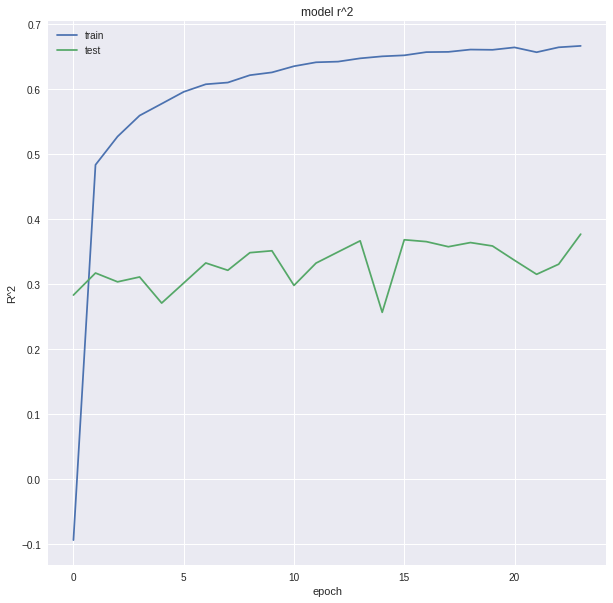

In [146]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

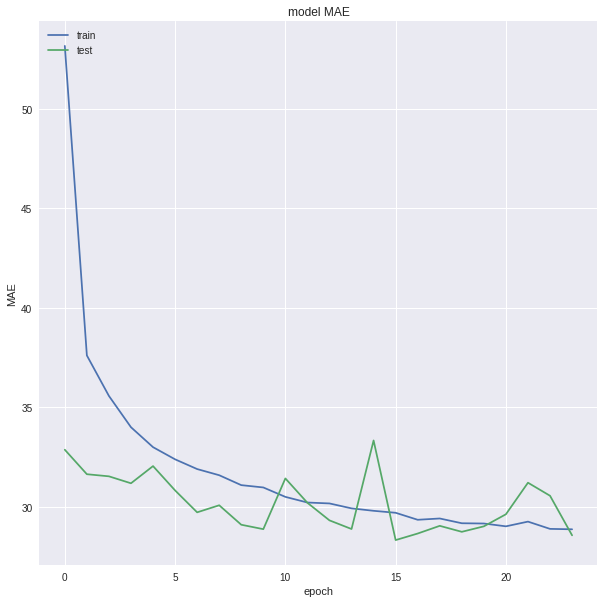

In [147]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

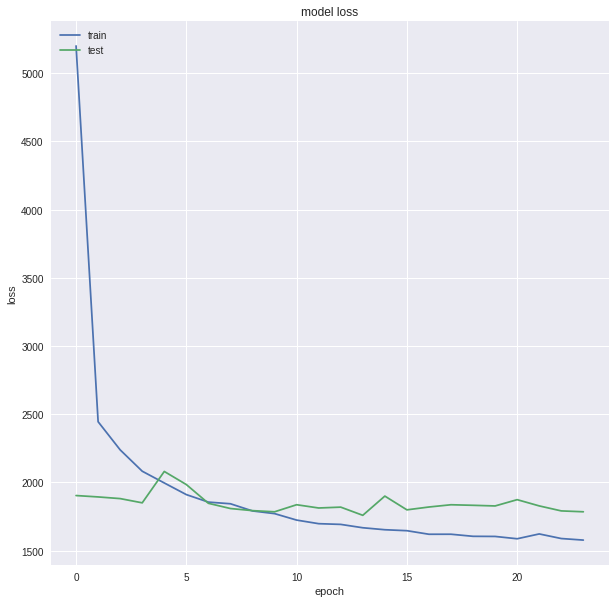

In [148]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

In [153]:
scores = model.evaluate(test_array, ytest, verbose=1, batch_size=200)
print('\nMAE (test): {}'.format(scores[1]))
print('\nR^2 (test): {}'.format(scores[2]))

preds = list(model.predict(test_array,verbose=1, batch_size=200))
predictions = []
for i in range(len(preds)):
  predictions.append(preds[i][0])

test['prediction'] = pd.DataFrame({'prediction':predictions})

13096/13096 [==============================] - 0s 25us/step

MAE (test): 31.291704271650925

R^2 (test): 0.2297539546421263
13096/13096 [==============================] - 0s 22us/step


In [154]:
test.head()

,id,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,cycle_norm,RUL,prediction
0,1,0.632184,0.750000,0.545181,0.310661,0.269413,1.0,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,0.00000,142,172.107010
1,1,0.344828,0.250000,0.150602,0.379551,0.222316,1.0,0.805153,0.166667,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827,0.00277,141,169.126068
2,1,0.517241,0.583333,0.376506,0.346632,0.322248,1.0,0.685990,0.227273,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.416667,0.728682,0.721348,0.00554,140,169.649094
3,1,0.741379,0.500000,0.370482,0.285154,0.408001,1.0,0.679549,0.196970,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.250000,0.666667,0.662110,0.00831,139,172.527710
4,1,0.580460,0.500000,0.391566,0.352082,0.332039,1.0,0.694042,0.166667,0.102396,0.273810,0.737740,0.220588,0.152751,0.300885,0.166667,0.658915,0.716377,0.01108,138,173.144653


In [0]:
predicted_rul = []
actual_rul = []
for i in test.id.unique():
  data = test[(test.id==i)].reset_index(drop = True)
  predicted_rul.append(data.prediction.iloc[-1])
  actual_rul.append(data.RUL.iloc[-1])

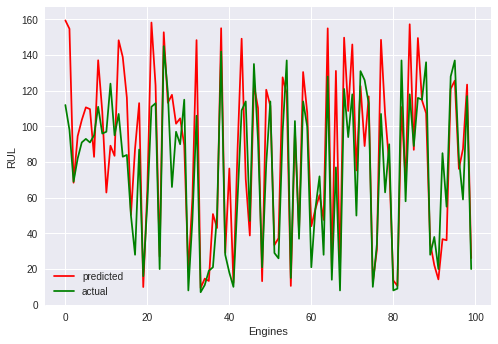

In [161]:
plt.plot(predicted_rul, color = 'red', label = 'predicted')
plt.plot(actual_rul, color = 'green', label = 'actual')
plt.legend()
plt.xlabel('Engines')
plt.ylabel('RUL')
plt.show()